In [1]:
#import libraries....

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import folium

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,confusion_matrix,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB,GaussianNB
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from mlxtend.classifier import StackingClassifier
from sklearn.preprocessing import Normalizer,MinMaxScaler,StandardScaler

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC

import datetime

import warnings
warnings.filterwarnings("ignore")

### Choosing metric
* From EDA part, It is sure that there is high class imbalance in the dataset. Also review_score 1,2,3 are very important, since misclassification of them would cause customer loss to the seller. So False positive should be the concern here. 
* Here precision and recall of each class is important. Precision of class 4,5 is more important and recall of 1,2,3 class is very important. So we can use f1 score,which is a combination of precision and recall, Since each is important to us we can consider Macro f1 score.. 
* Based on this observation and business problem, I choose Macro F1 score as metric. Also I want to check multi-class confusion matrix, so that we can observe the misclassification easily.

<b>Metric choosen,
    * Macro F1 score
    * Multi-class Confusion matrix

### Multi class classification among 1,2,3,4

In [2]:
#load the data with all created features
data = pd.read_csv("data_with_advanced_features.csv")
data.drop("Unnamed: 0", inplace=True, axis=1)

In [3]:
#label encoding of seller_id
label = LabelEncoder()
seller = label.fit_transform(data.seller_id)
data["seller_id"] = seller


#label encoding of product id
label = LabelEncoder()
product = label.fit_transform(data.product_id)
data["product_id"] = product


In [4]:
#let us drop some of the columns which are not needed
data.drop(["order_id","customer_id","order_status","order_approved_at","order_delivered_carrier_date",
           "order_estimated_delivery_date","order_delivered_customer_date","customer_unique_id","customer_city",
          "seller_city","shipping_limit_date","seller_state","customer_state",
           "order_purchase_timestamp"],inplace=True,axis=1)

In [5]:
#shape of the data after dropping unnecessary columns
data.shape

(113105, 57)

## 1.1 Stratified Splitting

In [6]:
data = data[data["review_score"]!=5]
Y = data["review_score"]
X = data

In [7]:
#train test split with test size 25% and 75% of data as train
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=10)

In [8]:
print("Dimensions of the splitted data :")
print("Train: ",x_train.shape,y_train.shape)
print("Test: ",x_test.shape,y_test.shape)

Dimensions of the splitted data :
Train:  (38774, 57) (38774,)
Test:  (9694, 57) (9694,)


In [9]:
#check the distribution of each class in train,test as well as original data
print("% Distribution of class labels in the total data :")
print(round(data["review_score"].value_counts(normalize=True)*100,2))
print("*"*50)

print("% Distribution of class labels in the train data :")
print(round(x_train["review_score"].value_counts(normalize=True)*100,2))
print("*"*50)

print("% Distribution of class labels in the test data :")
print(round(x_test["review_score"].value_counts(normalize=True)*100,2))
print("*"*50)


% Distribution of class labels in the total data :
4    44.82
1    27.32
3    19.75
2     8.11
Name: review_score, dtype: float64
**************************************************
% Distribution of class labels in the train data :
4    44.82
1    27.32
3    19.75
2     8.11
Name: review_score, dtype: float64
**************************************************
% Distribution of class labels in the test data :
4    44.82
1    27.32
3    19.75
2     8.11
Name: review_score, dtype: float64
**************************************************


* Distribution of each class label is same in train.test and original data.


<b> let us use simple CountVectorizer for categorical data.

## 1.2 Featurization:

### 1.2.1 Vectorization of categorical variables:

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

<b>1. payment_type

In [11]:
#payment_type 
vec = CountVectorizer()

vec.fit(x_train["payment_type"].values)

x_tr_pay_type = vec.transform(x_train.payment_type.values)
x_te_pay_type = vec.transform(x_test.payment_type.values)

print(x_tr_pay_type.shape)
print(x_te_pay_type.shape)


(38774, 4)
(9694, 4)


<b>2. order_item_id

In [12]:
x_train.order_item_id = x_train.order_item_id.astype(str)
x_test.order_item_id = x_test.order_item_id.astype(str)

In [13]:
#order_item_id 
vec = CountVectorizer(vocabulary=range(1,22))

vec.fit(x_train["order_item_id"])

x_tr_id = vec.transform(x_train.order_item_id)
x_te_id = vec.transform(x_test.order_item_id)

print(x_tr_id.shape)

print(x_te_id.shape)


(38774, 21)
(9694, 21)


<b>3. product_category_name

In [14]:
#product_category_name
vec = CountVectorizer()

vec.fit(x_train["product_category_name"].values)

x_tr_cat = vec.transform(x_train.product_category_name.values)
#x_cv_cat = vec.transform(x_cv.product_category_name.values).toarray()
x_te_cat = vec.transform(x_test.product_category_name.values)

print(x_tr_cat.shape)
#print(x_cv_cat.shape)
print(x_te_cat.shape)


(38774, 72)
(9694, 72)


### 1.2.2 Binary features

In [15]:
x_tr_same_state = x_train.same_state.values.reshape(-1,1)
x_te_same_state = x_test.same_state.values.reshape(-1,1)

x_tr_same_city = x_train.same_city.values.reshape(-1,1)
x_te_same_city = x_test.same_city.values.reshape(-1,1)

x_tr_late_shipping = x_train.late_shipping.values.reshape(-1,1)
x_te_late_shipping = x_test.late_shipping.values.reshape(-1,1)

x_tr_high_freight = x_train.high_freight.values.reshape(-1,1)
x_te_high_freight = x_test.high_freight.values.reshape(-1,1)

### 1.2.3 Numrical features

In [16]:

def scaling(train_data,test_data):
    """This function will standardize the numerical data"""
    norm = StandardScaler()

    norm.fit(train_data.values)

    x_tr_num = norm.transform(train_data.values)
    x_te_num = norm.transform(test_data.values)


    return x_tr_num,x_te_num

In [17]:
data.columns

Index(['payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_score', 'zip_code_prefix_customer',
       'lat_customer', 'lng_customer', 'product_id', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_item_id', 'seller_id', 'price', 'freight_value',
       'zip_code_prefix_seller', 'lat_seller', 'lng_seller',
       'product_category_name', 'estimated_time', 'actual_time',
       'diff_actual_estimated', 'diff_purchased_approved',
       'diff_purchased_courrier', 'distance', 'speed', 'same_state',
       'same_city', 'late_shipping', 'high_freight', 'seller_share',
       'bs_share', 'cust_share', 'bu_share', 'similarity',
       'seller_category_share', 'cat_seller_share', 'cust_category_share',
       'cat_cust_share', 'similarity_using_cat', 'size', 'delivery_day',
       'delivery_date', 'delivery_month', 'del

In [18]:
#data to be standardized
tr = x_train[["payment_sequential","payment_installments","payment_value","seller_id","product_id","seller_share","bu_share",
              "bs_share","cust_share",
          "lat_customer","lng_customer","lat_seller","lng_seller","product_name_lenght","product_description_lenght",
           "product_photos_qty","product_weight_g","size","price","delivery_day","delivery_date","delivery_month",
              "delivery_hour","purchased_day","purchased_date","purchased_month","purchased_hour","num_of_customers_for_seller",
              "num_of_sellers_for_cust","total_order_for_seller",
           "freight_value","estimated_time","actual_time","diff_actual_estimated","diff_purchased_approved",
           "diff_purchased_courrier","distance","speed","similarity","similarity_using_cat"]]

te = x_test[["payment_sequential","payment_installments","payment_value","seller_id","product_id","seller_share","bu_share",
              "bs_share","cust_share",
          "lat_customer","lng_customer","lat_seller","lng_seller","product_name_lenght","product_description_lenght",
           "product_photos_qty","product_weight_g","size","price","delivery_day","delivery_date","delivery_month",
              "delivery_hour","purchased_day","purchased_date","purchased_month","purchased_hour","num_of_customers_for_seller",
              "num_of_sellers_for_cust","total_order_for_seller",
           "freight_value","estimated_time","actual_time","diff_actual_estimated","diff_purchased_approved",
           "diff_purchased_courrier","distance","speed","similarity","similarity_using_cat"]]


In [19]:
#standardizing
x_tr_num,x_te_num = scaling(tr,te)

In [20]:
from scipy.sparse import hstack
#horizontal stacking of all the features
train = hstack((x_tr_pay_type,x_tr_id,x_tr_cat,x_tr_num,x_tr_same_state,
                   x_tr_same_city,x_tr_late_shipping,x_tr_high_freight)).toarray()

test = hstack((x_te_pay_type,x_te_id,x_te_cat,x_te_num,x_te_same_state,
                 x_te_same_city,x_te_late_shipping,x_te_high_freight)).toarray()

In [21]:
#shape of final train and test data
print("Shape of train data : ",train.shape)
print("Shape of test data : ",test.shape)

Shape of train data :  (38774, 141)
Shape of test data :  (9694, 141)


In [22]:
#reset the index of target variable
y_trains = y_train.reset_index()
y_train = y_trains["review_score"]

y_tests = y_test.reset_index()
y_test = y_tests["review_score"]

<b> Plotting Confusion matrix

In [23]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    """This function will plot confusion matrix, precision matrix and recall matrix"""
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [1,2,3,4]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(16,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(16,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(16,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

### Custom Ensemble Model

In [24]:
def custom_ensemble(x_tr,y_tr,x_te,n_estimators,estimator,meta_clf):
    """This function creates the custom ensemble model and returns predicted  target variable of test set"""
    
    ########### SPlitting train data into 50-50 as d1 and d2 ############
    kf = StratifiedKFold(n_splits=2)
    
    d1 = x_tr[list(kf.split(x_tr,y_tr))[1][0]]
    d1_y = y_tr[list(kf.split(x_tr,y_tr))[1][0]]

    d2 = x_tr[list(kf.split(x_tr,y_tr))[1][1]]
    d2_y = y_tr[list(kf.split(x_tr,y_tr))[1][1]]
    #####################################################################
    d1_y = np.array(d1_y)
    d2_y = np.array(d2_y)
    #####################################################################
    ### Creating base learners and training them using samples of d1 ####
    
    models=[]
    
    for i in tqdm(range(n_estimators)):
        ind = np.random.choice(19387,size=(20000),replace=True)
        sample = d1[ind]
        sample_y = d1_y[ind]  
        
        estimator.fit(sample,sample_y)
        models.append(estimator)
        
    ########### Predictions from base learners for d2 set ###############
    predictions = []
    for model in models: 
        
        pred = model.predict(d2)
        predictions.append(pred)
        
    predictions = np.array(predictions).reshape(-1,n_estimators)
    
    ########## meta classifier on predictions of base learners ##########
    
    meta_clf.fit(predictions,d2_y)
    train_pred = meta_clf.predict(predictions)
    
    #####################################################################
    ######################## TEST SET ###################################
    
    pred_test = []
    for model in models:
        pred_test.append(model.predict(test))
        
    pred_test = np.array(pred_test).reshape(-1,n_estimators)
    test_y_predicted = meta_clf.predict(pred_test)
    
#### Return train predictions on d2, test predictions and actual labels of d2 ####

    return train_pred,test_y_predicted,d2_y
    

### XGBoost

In [25]:
from tqdm import tqdm

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=10 is : 0.224150882259233
Test Macro F1 score for n_estimator=10 is : 0.21402354760335549
************************************************************


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=15 is : 0.22392244223495328
Test Macro F1 score for n_estimator=15 is : 0.2164202146921711
************************************************************


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=25 is : 0.22600140966296
Test Macro F1 score for n_estimator=25 is : 0.20138471771785552
************************************************************


  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=50 is : 0.2434099278470572
Test Macro F1 score for n_estimator=50 is : 0.22614025045401542
************************************************************


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=75 is : 0.25323918584721616
Test Macro F1 score for n_estimator=75 is : 0.22253416709921922
************************************************************


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=100 is : 0.25423265160473507
Test Macro F1 score for n_estimator=100 is : 0.21458590820933002
************************************************************


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=120 is : 0.2615328821806365
Test Macro F1 score for n_estimator=120 is : 0.22263530316268562
************************************************************


  0%|                                                                                          | 0/175 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=150 is : 0.2671827766533982
Test Macro F1 score for n_estimator=150 is : 0.22294645761774798
************************************************************


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=175 is : 0.26910757998417345
Test Macro F1 score for n_estimator=175 is : 0.21497758696955044
************************************************************


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [1:23:17<00:00, 24.99s/it]


************************************************************
Train Macro F1 score for n_estimator=200 is : 0.2710447671822724
Test Macro F1 score for n_estimator=200 is : 0.22493819803903675
************************************************************


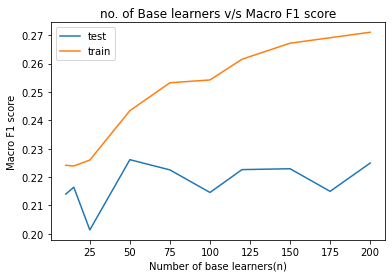

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [20:46<00:00, 24.93s/it]


************************************************************
Train Macro F1 score for n_estimator=50 is : 0.24604171363035154
Test Macro F1 score for n_estimator=50 is : 0.23023241796944321
************************************************************
-------------------- Confusion matrix --------------------


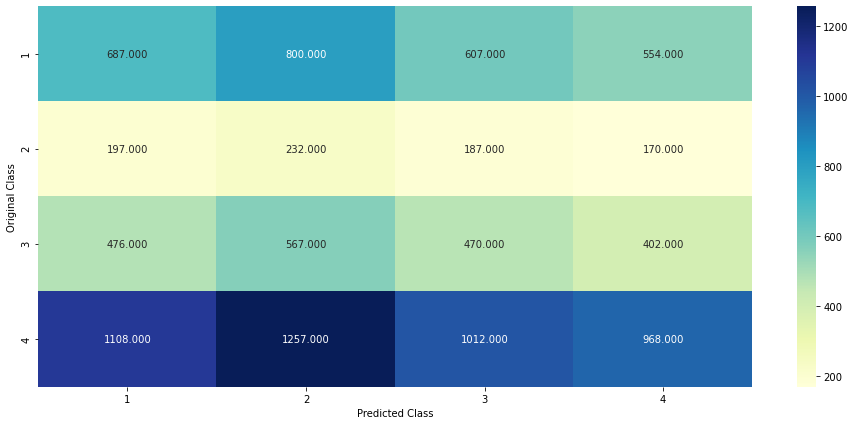

-------------------- Precision matrix (Columm Sum=1) --------------------


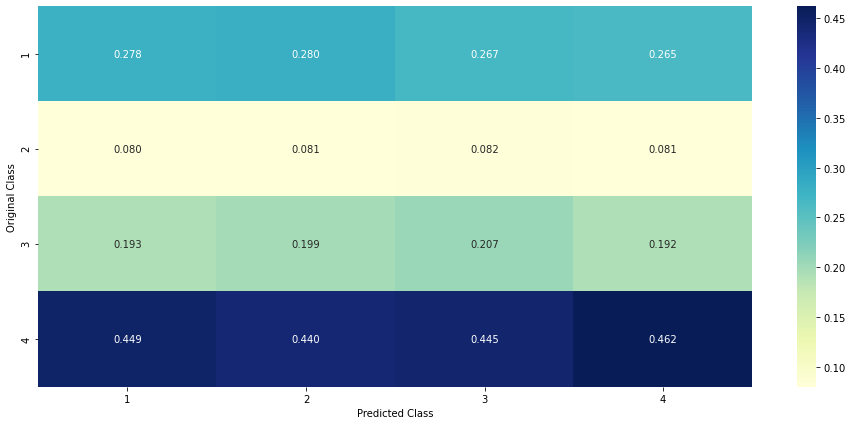

-------------------- Recall matrix (Row sum=1) --------------------


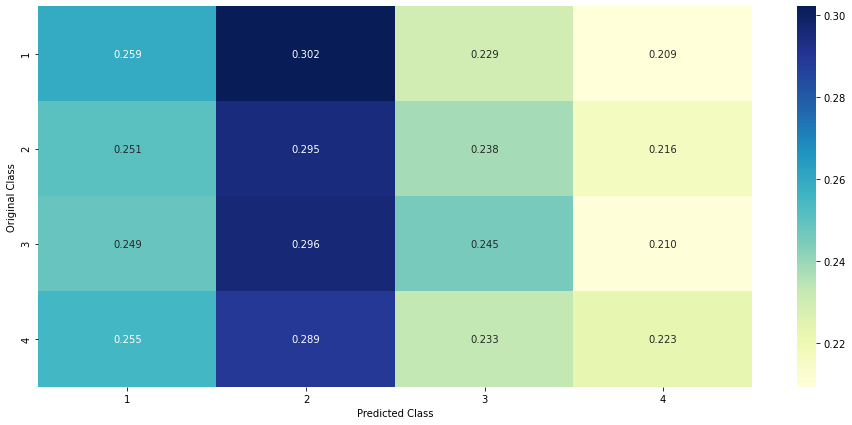

In [26]:
n = [10,15,25,50,75,100,120,150,175,200]
test_f1 =[]
train_f1 = []

for i in n:
    
    train_pred,test_pred,d2_y = custom_ensemble(train,y_train,test,i,xgb.XGBClassifier(class_weight="balanced", verbosity = 0),
                                       LogisticRegression(class_weight="balanced"))
    
    train_score = f1_score(d2_y,train_pred,average="macro",labels=[1,2,3,4])
    test_score = f1_score(y_test,test_pred,average="macro",labels=[1,2,3,4])
    
    train_f1.append(train_score)
    test_f1.append(test_score)
    
    print("*"*60)
    print("Train Macro F1 score for n_estimator={} is : {}".format(i,train_score))
    print("Test Macro F1 score for n_estimator={} is : {}".format(i,test_score))
    print("*"*60)
    
plt.plot(n,test_f1,label="test")
plt.plot(n,train_f1,label="train")
plt.legend()
plt.xlabel("Number of base learners(n)")
plt.ylabel("Macro F1 score")
plt.title("no. of Base learners v/s Macro F1 score")
plt.show()

best_n = n[np.argmax(test_f1)]


train_pred,test_pred,d2_y = custom_ensemble(train,y_train,test,best_n,xgb.XGBClassifier(class_weight="balanced", verbosity = 0),
                                       LogisticRegression(class_weight="balanced"))
    
train_score = f1_score(d2_y,train_pred,average="macro",labels=[1,2,3,4])
test_score = f1_score(y_test,test_pred,average="macro",labels=[1,2,3,4])
    
print("*"*60)
print("Train Macro F1 score for n_estimator={} is : {}".format(best_n,train_score))
print("Test Macro F1 score for n_estimator={} is : {}".format(best_n,test_score))
print("*"*60)

plot_confusion_matrix(y_test,test_pred)

### Random Forest

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=10 is : 0.22405613381089057
Test Macro F1 score for n_estimator=10 is : 0.21920306884632607
************************************************************


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=15 is : 0.23304134799202597
Test Macro F1 score for n_estimator=15 is : 0.21627905646598805
************************************************************


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=25 is : 0.22837898160357428
Test Macro F1 score for n_estimator=25 is : 0.21716976368148258
************************************************************


  0%|                                                                                           | 0/75 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=50 is : 0.2418932048352555
Test Macro F1 score for n_estimator=50 is : 0.22587235251077167
************************************************************


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=75 is : 0.2541101995383969
Test Macro F1 score for n_estimator=75 is : 0.2247474165547334
************************************************************


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=100 is : 0.2473386003766883
Test Macro F1 score for n_estimator=100 is : 0.21535929389616748
************************************************************


  0%|                                                                                          | 0/150 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=120 is : 0.2565776631753257
Test Macro F1 score for n_estimator=120 is : 0.2197360892588105
************************************************************


  0%|                                                                                          | 0/175 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=150 is : 0.2592542562040726
Test Macro F1 score for n_estimator=150 is : 0.2248717103016893
************************************************************


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

************************************************************
Train Macro F1 score for n_estimator=175 is : 0.2728584213381682
Test Macro F1 score for n_estimator=175 is : 0.22458829979610465
************************************************************


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [32:54<00:00,  9.87s/it]


************************************************************
Train Macro F1 score for n_estimator=200 is : 0.26785200259517666
Test Macro F1 score for n_estimator=200 is : 0.22673741495403862
************************************************************


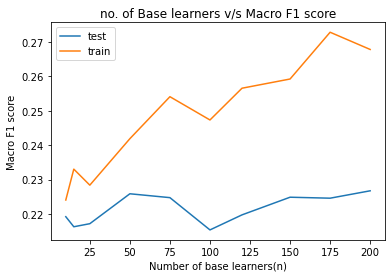

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [32:56<00:00,  9.88s/it]


************************************************************
Train Macro F1 score for n_estimator=200 is : 0.27199880277608407
Test Macro F1 score for n_estimator=200 is : 0.2287252929706321
************************************************************
-------------------- Confusion matrix --------------------


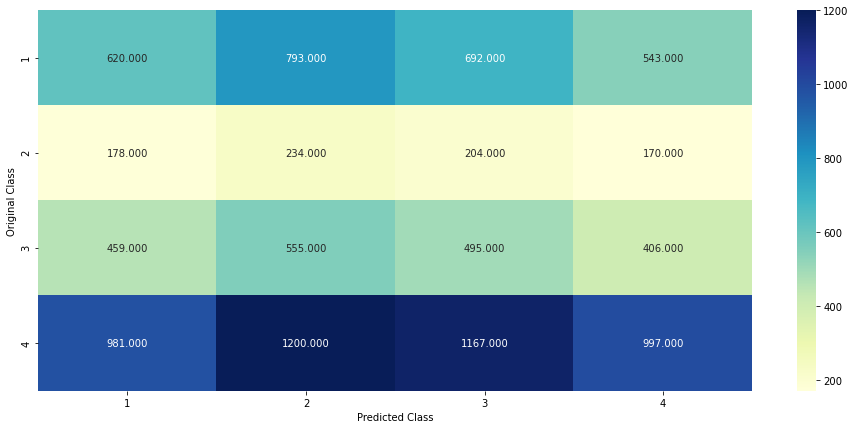

-------------------- Precision matrix (Columm Sum=1) --------------------


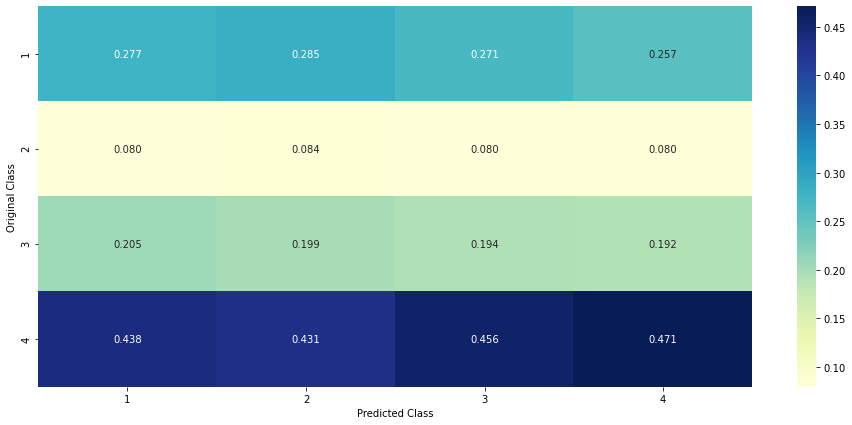

-------------------- Recall matrix (Row sum=1) --------------------


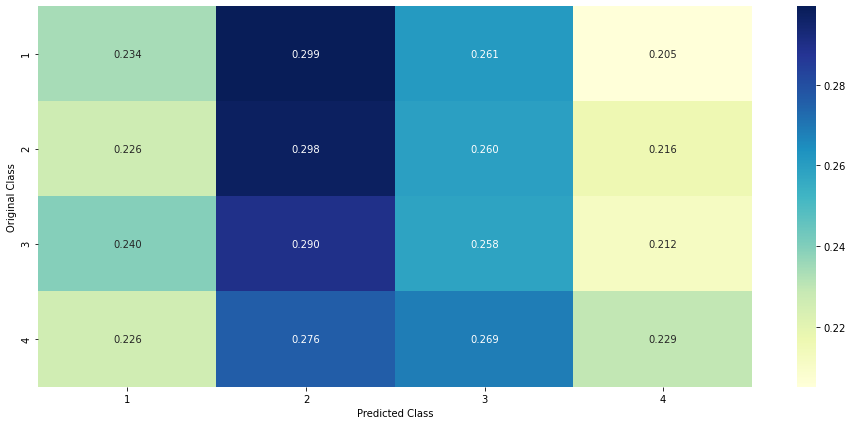

In [27]:
n = [10,15,25,50,75,100,120,150,175,200]
test_f1 =[]
train_f1 = []

for i in n:
    
    train_pred,test_pred,d2_y = custom_ensemble(train,y_train,test,i,RandomForestClassifier(class_weight="balanced"),
                                       LogisticRegression(class_weight="balanced"))
    
    train_score = f1_score(d2_y,train_pred,average="macro",labels=[1,2,3,4])
    test_score = f1_score(y_test,test_pred,average="macro",labels=[1,2,3,4])
    
    train_f1.append(train_score)
    test_f1.append(test_score)
    
    print("*"*60)
    print("Train Macro F1 score for n_estimator={} is : {}".format(i,train_score))
    print("Test Macro F1 score for n_estimator={} is : {}".format(i,test_score))
    print("*"*60)
    
plt.plot(n,test_f1,label="test")
plt.plot(n,train_f1,label="train")
plt.legend()
plt.xlabel("Number of base learners(n)")
plt.ylabel("Macro F1 score")
plt.title("no. of Base learners v/s Macro F1 score")
plt.show()

best_n = n[np.argmax(test_f1)]


train_pred,test_pred,d2_y = custom_ensemble(train,y_train,test,best_n,RandomForestClassifier(class_weight="balanced"),
                                       LogisticRegression(class_weight="balanced"))
    
train_score = f1_score(d2_y,train_pred,average="macro",labels=[1,2,3,4])
test_score = f1_score(y_test,test_pred,average="macro",labels=[1,2,3,4])
    
print("*"*60)
print("Train Macro F1 score for n_estimator={} is : {}".format(best_n,train_score))
print("Test Macro F1 score for n_estimator={} is : {}".format(best_n,test_score))
print("*"*60)

plot_confusion_matrix(y_test,test_pred)